<a href="https://www.kaggle.com/code/felixfaruix/titanic-randomforest?scriptVersionId=250695895" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

## Titanic - Machine Learning from Disaster

This notebook is part of a _**Kaggle Competition**_ for the _Titanic_ dataset. The dataset is divided into train and test, where our goal is to predict what passengers survived the sank. We will do it using machine learning techniques and data science approach on the training data, building a model trying to predict the survivals on the test data. 

In [1]:
"""Importing necessary libraries for the Titanic dataset analysis.
This script is part of a Kaggle competition notebook for the Titanic dataset."""

import pandas as pd 
import sklearn as sk
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import os
import sys

In [2]:
# Load the Titanic dataset
# Ensure the correct path to the dataset files
# Adjust the path as necessary based on your directory structure
train_data = pd.read_csv('/kaggle/input/titanic/train.csv')
test_data = pd.read_csv('/kaggle/input/titanic/test.csv')

_Head()_ tells us the first 5 rows of the dataset, which is useful to understand the structure and content of the data.
As we can see, the dataset contains information about passengers such as their survival status, class, name and other features.     
This is useful to understand the structure and content of the data, and to identify any **potential issues or missing values** in the dataset.
We get a quick overview of the dataset, including the number of rows and columns, and the data types of each column.

More information can be obtained using the _info()_ and _describe()_ methods. Info method is particularly useful to understand the data types and missing values in the dataset, while describe() method gives us a statistical summary of the numerical columns.

In [3]:
# First 225 rows of the training data
train_data.head()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
# Get a quick overview of the dataset
train_data.info()
train_data.describe()
train_data.info()
train_data.describe()



# Parch shows the number of parents/children aboard, this one shows that most of the passengers were alone. 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


The dataset is missing some values, especially in the '**Age**' and '**Embarked**' columns.
We can also see that the 'Survived' column is the target variable, which we will use to train our model.

 _Describe()_ shows that most of the people did not survive, which is expected as the Titanic sank.
The '**Pclass**' column indicates the class of the ticket, which is also an important feature to consider. This one shows that most of the passengers were in the 3rd class, which is expected as it was the cheapest ticket.
'**Parch**' column shows the number of parents/children aboard, pointing out that most of the passengers were alone. 

As our next step, we will now plot the correlation heatmap indicating the degree of linkage between each feature.


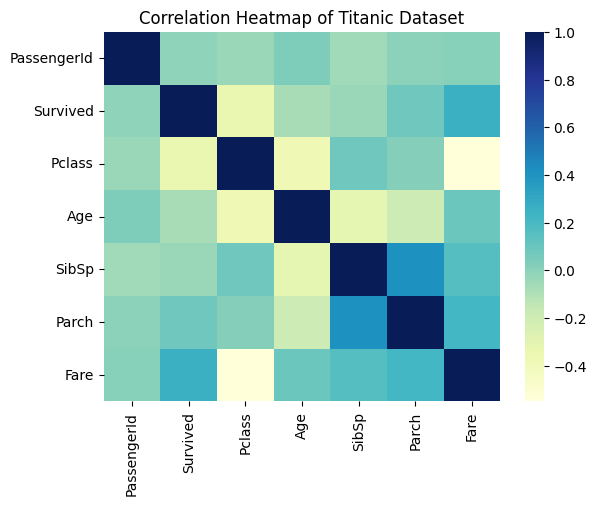

In [5]:
# Plotting only int or float columns correlations
numeric_df = train_data.select_dtypes(include=["int64", "float64"])
sns.heatmap(numeric_df.corr(), cmap='YlGnBu')
plt.title('Correlation Heatmap of Titanic Dataset')
plt.show()

#### Splitting our train set via stratified shuffle split from _sklearn_

Now we want to split our _train_data_ into train and test sets, but with preserved class proportions. 

- We shuffle our dataset randomly via **StratifiedShuffleSplit** from _sklearn_
- Then we split it into train and test sets (80%/20%)
- WHile preserving the distribution of different target variables in both sets (Survived, Pclass, Sex)

This is important when the class is imbalanced like in this case, where the survival rate is low. 


In [6]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits = 1, test_size=0.2, random_state=42)
for train_indeces, test_indeces in split.split(train_data, train_data[["Survived", "Sex"]]):
    strat_train_set = train_data.loc[train_indeces].reset_index(drop=True)
    strat_test_set = train_data.loc[test_indeces].reset_index(drop=True)

We plot each distirbution across the two sets, in order to verify that they are actually equal across each different variable. 

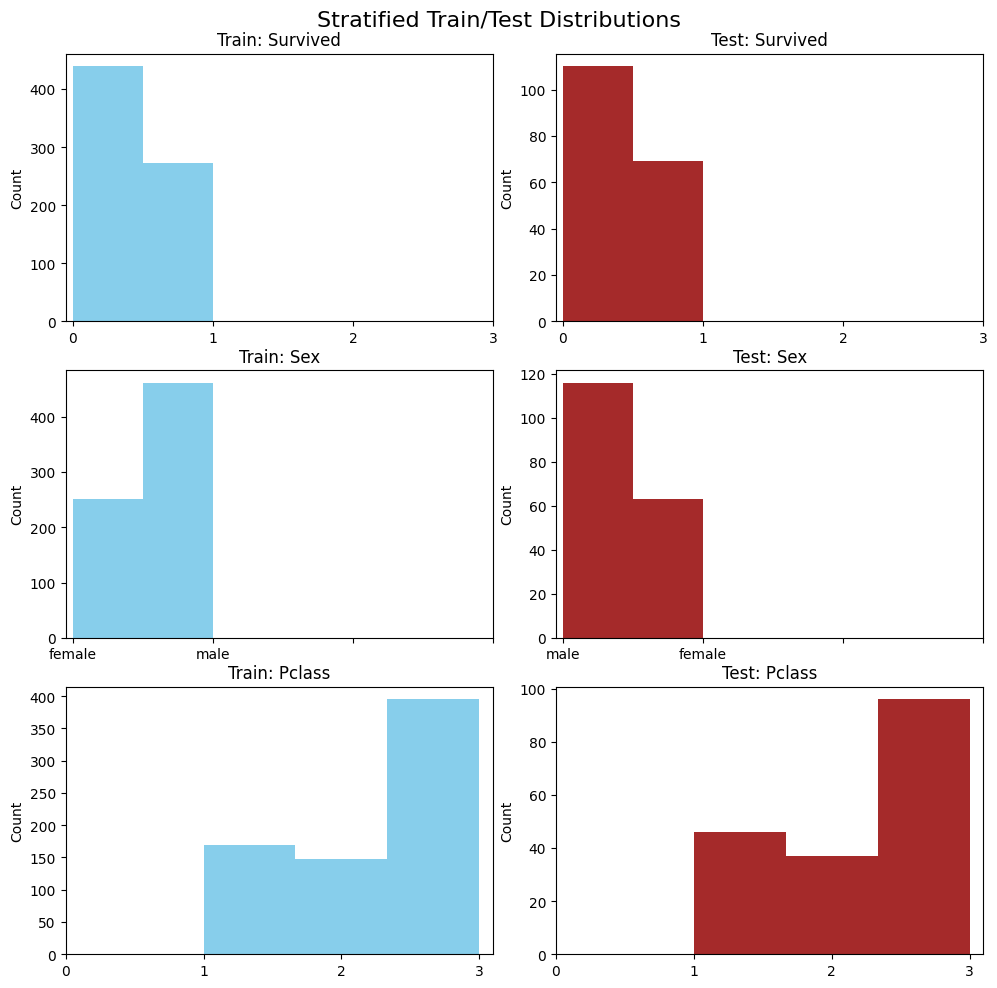

In [7]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(3, 2, figsize=(10, 10))
fig.suptitle("Stratified Train/Test Distributions", fontsize=16)

# Row 1: Survived
axes[0, 0].hist(strat_train_set["Survived"], bins=2, color="skyblue")
axes[0, 0].set_title("Train: Survived")
axes[0, 1].hist(strat_test_set["Survived"], bins=2, color="brown")
axes[0, 1].set_title("Test: Survived")

# Row 2: Sex
axes[1, 0].hist(strat_train_set["Sex"], bins=2, color="skyblue")
axes[1, 0].set_title("Train: Sex")
axes[1, 1].hist(strat_test_set["Sex"], bins=2, color="brown")
axes[1, 1].set_title("Test: Sex")

# Row 3: Pclass
axes[2, 0].hist(strat_train_set["Pclass"], bins=3, color="skyblue")
axes[2, 0].set_title("Train: Pclass")
axes[2, 1].hist(strat_test_set["Pclass"], bins=3, color="brown")
axes[2, 1].set_title("Test: Pclass")

# Clean up
for ax in axes.flat:
    ax.set_xticks([0, 1, 2, 3])
    ax.set_xlabel("")
    ax.set_ylabel("Count")

plt.tight_layout(pad = 0.8, h_pad= 0.2, w_pad= 0.2)
plt.show()

In [8]:
strat_train_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 712 entries, 0 to 711
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  712 non-null    int64  
 1   Survived     712 non-null    int64  
 2   Pclass       712 non-null    int64  
 3   Name         712 non-null    object 
 4   Sex          712 non-null    object 
 5   Age          567 non-null    float64
 6   SibSp        712 non-null    int64  
 7   Parch        712 non-null    int64  
 8   Ticket       712 non-null    object 
 9   Fare         712 non-null    float64
 10  Cabin        166 non-null    object 
 11  Embarked     711 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 66.9+ KB


In [9]:
strat_test_set.info()   

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 179 entries, 0 to 178
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  179 non-null    int64  
 1   Survived     179 non-null    int64  
 2   Pclass       179 non-null    int64  
 3   Name         179 non-null    object 
 4   Sex          179 non-null    object 
 5   Age          147 non-null    float64
 6   SibSp        179 non-null    int64  
 7   Parch        179 non-null    int64  
 8   Ticket       179 non-null    object 
 9   Fare         179 non-null    float64
 10  Cabin        38 non-null     object 
 11  Embarked     178 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 16.9+ KB


In [10]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.1+ KB


### Feature Engineering 

For first, we need to fill the gaps in the Age column. 
Then, we will have to drop the name column, which is a string, not brining any value to our feature space, except the title from name, which could be useful for in relation to their class. Then, we will also transform our '**Sex**' column into a binary variable (0: Male - 1: Female). 

We will also drop '**Cabin**' column and keep a bianry flag if there is any cabin code at all. Finally, we will transform into integers the values from the '**Embarked**' as one hot encoding, which is a common technique to convert categorical variables into numerical ones.

In [11]:
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin


class CabinFLagger(BaseEstimator, TransformerMixin):
    """Transformer to create a binary flag for the presence of a cabin."""
    def __init__(self, columns=("Cabin",)):
        self.columns = list(columns)

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        # Create a binary flag for the presence of a cabin
        X["hasCabin"]= X["Cabin"].notnull().astype(int)
        return X.drop(columns=self.columns, errors="ignore").copy() #may or may not be a view so we add .copy() to avoid SettingWithCopyWarning

class FeatureDropper(BaseEstimator, TransformerMixin):
    """Transformer to drop specified features from the DataFrame."""
    def __init__(self, columns: tuple):
        if columns is None:
            columns = ["Ticket"]
        self.columns = list(columns)
    # Initialize with the columns to drop, defaulting to "Ticket"
    def fit(self, X, y=None): 
        return self
    # Drop specified features from the DataFrame
    def transform(self, X):
        X = X.copy()
        # Drop specified features
        return X.drop(columns = self.columns, errors="ignore").copy()
    
class TitleExtractor(BaseEstimator, TransformerMixin):
    """Transformer to extract titles from names in the DataFrame."""

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        # Extract titles from names
        X["Title"] = X["Name"].str.extract(r' ([A-Za-z]+)\.', expand=False)
        return X.drop(columns=["Name"], errors="ignore").copy()
    
class AgeImputer(BaseEstimator, TransformerMixin):

    def __init__(self):
        self.groups = ["Pclass", "Sex", "Title"]
        self.age_median = None # Will hold the median age for each group

    def fit(self, X, y=None):
        # Group by specified features and calculate the median age for each group
        # groupby() loops over the dataset and calculates the median age for each group with median()
        # and reset_index() to convert the result back to a DataFrame (because we get a Series otherwise)
        # rename() to change the column name to "GroupMedian"
        self.age_medians = (X.groupby(self.groups)["Age"].median().reset_index()
                              .rename(columns={"Age": "GroupMedian"}))
        return self
    
    def transform(self, X):
        X = X.copy()
        # Merge to assign group median to each row where the groups are defined
        X = pd.merge(X, self.age_medians, on=self.groups, how="left")
        # Fill missing Age with group median
        X["Age"] = X["Age"].fillna(X["GroupMedian"])
        return X.drop(columns=["GroupMedian"], errors="ignore").copy()

class TitleOneHotEncoder(BaseEstimator, TransformerMixin):

    def __init__(self):
        self.encoder = OneHotEncoder(sparse_output=False, handle_unknown="ignore")

    def fit(self, X, y=None):
        self.encoder.fit(X[["Title"]])
        X['Title'] = X['Title'].replace(['Mlle', 'Ms', 'Lady', 'Countess', 'the_Countess' 'Mme', 'Dona'], 'Miss')
        X['Title'] = X['Title'].replace(['Rev', 'Don', 'Capt', 'Major', 'Sir', 'Col', 'Jonkheer'], 'Rare')
        return self

    def transform(self, X):
        X = X.copy()
        title_encoded = np.asarray(self.encoder.transform(X[["Title"]]))
        # Now we group all the rare titles into "Rare", and under miss as well  and encode the rest
        # Create a DataFrame with the encoded titles
        title_df = pd.DataFrame(data = title_encoded, index = X.index, 
                                columns=self.encoder.get_feature_names_out(["Title"]))
        return pd.concat([X.drop(columns=["Title"], errors="ignore").copy(), title_df], axis=1)
    
class SexLabelEncoder(BaseEstimator, TransformerMixin):
    """Transformer to encode the Sex column into binary values."""

    def fit (self, X, y=None):
        # No fitting needed for label encoding
        return self 

    def transform(self, X):
        X = X.copy()
        # Encode    
        X["Sex"] = X["Sex"].map({"male": 1, "female": 0}).astype(int)
        # Ensure the column is of type int
        return X
    
class EmbarkedLabelEncoder(BaseEstimator, TransformerMixin):
    """Transformer to hot-encode Embarked column."""

    def __init__(self):
        self.encoder = OneHotEncoder(sparse_output=False, handle_unknown="ignore")

    def fit(self, X, y=None):
        self.encoder.fit(X[["Embarked"]])
        return self
    def transform(self, X):
        X = X.copy()
        embarked_encoded = np.asarray(self.encoder.transform(X[["Embarked"]]))
        # Create a DataFrame with the encoded embarked values
        embarked_df = pd.DataFrame(data=embarked_encoded, index=X.index,
                                   columns=self.encoder.get_feature_names_out(["Embarked"]))
        return pd.concat([X.drop(columns=["Embarked"], errors="ignore").copy(), embarked_df], axis=1)

class isAloneFlagger(BaseEstimator, TransformerMixin):
    """Transformer to create a binary flag indicating if a passenger is alone."""
    
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        # Create a binary flag for being alone
        X["isAlone"] = ((X["SibSp"] == 0) & (X["Parch"] == 0)).astype(int)
        return X

class NormalizeFare(BaseEstimator, TransformerMixin):
    """Transformer to normalize the Fare column."""
    
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        # Normalize Fare by dividing by the maximum Fare value
        X["Fare"] = X["Fare"] / X["Fare"].max()
        return X

class isMinorFlagger(BaseEstimator, TransformerMixin):
    """Transformer to create a binary flag indicating if a passenger is a minor."""
    
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        # Create a binary flag for being a minor
        X["isMinor"] = (X["Age"] < 16).astype(int)
        return X

class familySizeFlagger(BaseEstimator, TransformerMixin):
    """Transformer to create a family size flag."""
    
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        # Create a family size feature
        X["FamilySize"] = X["SibSp"] + X["Parch"] + 1  # +1 for the passenger themselves
        return X

In [12]:
from sklearn.pipeline import Pipeline

preprocess_pipe = Pipeline([
    ("cabin", CabinFLagger()),
    ("feature_drop",  FeatureDropper(("Ticket",))),
    ("Tirle_extractor",  TitleExtractor()),
    ("age_imputer", AgeImputer()),
    ("Sex_flagger", SexLabelEncoder()),
    ("Embarked_encoder", EmbarkedLabelEncoder()),
    ("isAlone_flagger", isAloneFlagger()),
    ("NormalizeFare", NormalizeFare()),
    ("isMinor_flagger", isMinorFlagger()),
    ("FamilySize_flagger", familySizeFlagger()),
    ("Title_one_hot_encoder", TitleOneHotEncoder()),
])

print("TRAIN cols :", list(strat_train_set.columns))
print("VAL cols :", list(strat_test_set.columns))
# fit + transform on training split
preprocessed_array = preprocess_pipe.fit_transform(strat_train_set)
strat_train_set = pd.DataFrame(preprocessed_array)
print(strat_train_set.head())

# transform ONLY on validation / test split
strat_test_set  = preprocess_pipe.transform(strat_test_set)
test_data_processed = preprocess_pipe.transform(test_data)
# Display the first few rows of the transformed training data


TRAIN cols : ['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked']
VAL cols : ['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked']
   PassengerId  Survived  Pclass  Sex   Age  SibSp  Parch      Fare  hasCabin  \
0          219         1       1    0  32.0      0      0  0.148911         1   
1          128         1       3    1  24.0      0      0  0.013940         0   
2          489         0       3    1  30.0      0      0  0.015713         0   
3          806         0       3    1  31.0      0      0  0.015176         0   
4          878         0       3    1  19.0      0      0  0.015412         0   

   Embarked_C  ...  Title_Lady  Title_Major  Title_Master  Title_Miss  \
0         1.0  ...         0.0          0.0           0.0         1.0   
1         0.0  ...         0.0          0.0           0.0         0.0   
2         0.0  ...         0.0      

/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less
  return op(a, b)


In [13]:
# Converting the transformed training set to a DataFrame for better visualization
strat_test_set = pd.DataFrame(strat_test_set)
test_data_processed = pd.DataFrame(test_data_processed)

# Display the first few rows of the transformed training data
test_data_processed.head()  

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,hasCabin,Embarked_C,Embarked_Q,...,Title_Lady,Title_Major,Title_Master,Title_Miss,Title_Mlle,Title_Mme,Title_Mr,Title_Mrs,Title_Rev,Title_Sir
0,892,3,1,34.5,0,0,0.015282,0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,893,3,0,47.0,1,0,0.013663,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,894,2,1,62.0,0,0,0.018909,0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,895,3,1,27.0,0,0,0.016908,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,896,3,0,22.0,1,1,0.023984,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [14]:
# Display the first few rows of the transformed test data
test_data_processed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 29 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   PassengerId     418 non-null    int64  
 1   Pclass          418 non-null    int64  
 2   Sex             418 non-null    int64  
 3   Age             417 non-null    float64
 4   SibSp           418 non-null    int64  
 5   Parch           418 non-null    int64  
 6   Fare            417 non-null    float64
 7   hasCabin        418 non-null    int64  
 8   Embarked_C      418 non-null    float64
 9   Embarked_Q      418 non-null    float64
 10  Embarked_S      418 non-null    float64
 11  Embarked_nan    418 non-null    float64
 12  isAlone         418 non-null    int64  
 13  isMinor         418 non-null    int64  
 14  FamilySize      418 non-null    int64  
 15  Title_Col       418 non-null    float64
 16  Title_Countess  418 non-null    float64
 17  Title_Dr        418 non-null    flo

In [15]:
# Display the info of the transformed training set
strat_train_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 712 entries, 0 to 711
Data columns (total 30 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   PassengerId     712 non-null    int64  
 1   Survived        712 non-null    int64  
 2   Pclass          712 non-null    int64  
 3   Sex             712 non-null    int64  
 4   Age             712 non-null    float64
 5   SibSp           712 non-null    int64  
 6   Parch           712 non-null    int64  
 7   Fare            712 non-null    float64
 8   hasCabin        712 non-null    int64  
 9   Embarked_C      712 non-null    float64
 10  Embarked_Q      712 non-null    float64
 11  Embarked_S      712 non-null    float64
 12  Embarked_nan    712 non-null    float64
 13  isAlone         712 non-null    int64  
 14  isMinor         712 non-null    int64  
 15  FamilySize      712 non-null    int64  
 16  Title_Col       712 non-null    float64
 17  Title_Countess  712 non-null    flo

We notice that the dataset is clean now. All the features have the same number of values. 

#### Training and Evaluation of the Model (Random Forest Classifier)

In [16]:
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier # type: ignore
from sklearn.metrics import accuracy_score
from catboost import CatBoostClassifier # type: ignore
 
# Features and target
X_train = strat_train_set.drop("Survived", axis=1)
y_train = strat_train_set["Survived"]
X_val = strat_test_set.drop("Survived", axis=1)
y_val = strat_test_set["Survived"]

# Base learners
estimators = [
    ('rf', RandomForestClassifier(n_estimators=500, max_depth=5, min_samples_split=5, random_state=42)),
    ('logreg', LogisticRegression(max_iter=8000)),
    ('xgb', XGBClassifier(eval_metric='logloss')),
     ('catboost', CatBoostClassifier(verbose=0))
]

# Stacking ensemble
stacked_clf = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(max_iter=8000),
    passthrough=True,
    cv=5
)

# Fit on training data
stacked_clf.fit(X_train, y_train)

# Predict on validation set
y_pred = stacked_clf.predict(X_val)

# Evaluate
acc = accuracy_score(y_val, y_pred)
print("Validation Accuracy:", acc)

Validation Accuracy: 0.8435754189944135


In [17]:

test_data_processed["Fare"] = test_data_processed["Fare"].ffill()
test_data_processed["Fare"].isna().sum()
test_data_processed["Age"] = test_data_processed["Age"].ffill()
test_data_processed["Age"].isna().sum()   # Should be 0 if all missing values are filled

0

In [18]:
test_data_processed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 29 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   PassengerId     418 non-null    int64  
 1   Pclass          418 non-null    int64  
 2   Sex             418 non-null    int64  
 3   Age             418 non-null    float64
 4   SibSp           418 non-null    int64  
 5   Parch           418 non-null    int64  
 6   Fare            418 non-null    float64
 7   hasCabin        418 non-null    int64  
 8   Embarked_C      418 non-null    float64
 9   Embarked_Q      418 non-null    float64
 10  Embarked_S      418 non-null    float64
 11  Embarked_nan    418 non-null    float64
 12  isAlone         418 non-null    int64  
 13  isMinor         418 non-null    int64  
 14  FamilySize      418 non-null    int64  
 15  Title_Col       418 non-null    float64
 16  Title_Countess  418 non-null    float64
 17  Title_Dr        418 non-null    flo

In [19]:
test_predictions = stacked_clf.predict(test_data_processed)
print("len(test_predictions):", len(test_predictions))# must be 418

len(test_predictions): 418


In [20]:
submission = pd.DataFrame({
    "PassengerId": test_data["PassengerId"],  # from the original unprocessed test.csv
    "Survived": test_predictions                   # model predictions
})
submission.to_csv("submission.csv", index=False)

In [21]:
check = pd.read_csv("submission.csv")
print("rows on disk      :", len(check))   

rows on disk      : 418
